# pyiron 
The integrated development environment (IDE) for computational materials science `pyiron` accelerates the rapid prototyping and up-scaling of simulation protocols. Internally, it consists of two primary components the `pyiron_atomistics` package, which provides the interfaces for atomistic simulations codes and atomistic simulation workflows and the `pyiron_base` package, which defines the job management and data storage interface. The latter is independent of the atomistic scale and addresses the general challenge of coupling simulation codes in reproducible workflows. Simulation codes can be integrated in the `pyiron_base` package by either using existing python bindings or alternatively by writing the input files, executing the simulation code and parsing the output files. The following explanations focus on the `pyiron_base` package as a workflow manager, which constructs simulation workflows by combining `job` objects like building blocks.

## Installation / Setup
The `pyiron_base` workflow manager can be installed via the python package index or the conda package manager. While no additional configuration is required to use `pyiron_base` on a workstation, the connection to an high performance computing (HPC) cluster requires some additional configuration. The `.pyiron` configuration file in the users home directory is used to specify the resource directory, which contains the configuration of the queuing system. 

## Implementation of a new simulation code
The `pyiron_base` workflow manager provides two interfaces to implement new simulation codes or simulation workflows. For simulation codes which already provide a python interface the `wrap_python_function()` function is used to convert any python function into a pyiron job object. In analogy external executables can be wrapped using the `wrap_executable()`. Based on these two functions any executable can be wrapped as `Job` object. By naming the `Job` object the user can easily reload the same calculation at any time. Furthermore, `pyiron_base` internally uses the name to generate a directory for each `Job` object to simplify locating the input and output of a given calculation for debugging: 

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.io import write
from adis_tools.parsers import parse_pw
from pyiron_base import job, Project

In [2]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=input_dict["structure"],
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

In [3]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": output["ase_structure"],
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

In [4]:
@job(output_key_lst=["energy", "volume", "structure"])
def calculate_qe(working_directory, input_dict):
    write_input(
        input_dict=input_dict,
        working_directory=working_directory,
    )
    subprocess.check_output(
        "mpirun -np 1 pw.x -in input.pwi > output.pwo",
        cwd=working_directory,
        shell=True,
    )
    return collect_output(working_directory=working_directory)

Finally, multiple simulation can be combined in a simulation protocol. In this case the optimization of an Aluminium lattice structure, the calculation of an energy volume curve and the plotting of the resulting curve. 

In [5]:
@job
def generate_structures(structure, strain_lst):
    structure_lst = []
    for strain in strain_lst:
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return structure_lst

In [6]:
@job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

# Structure optimization 

In [8]:
structure = bulk(
    name="Al",
    a=4.05,
    cubic=True,
)

In [9]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

As the quantum espresso calculations are the computationally expensive steps they are combined in a python function to be submitted to dedicated computing resources. In contrast the creation of the atomistic structure and the plotting of the energy volume curve are executed in the users process.

The remaining simulation protocol, can be summarized in a few lines. The required modules are imported, a `Project` object is created which represents a folder on the filesystem, the `wrap_python_function()` is used to convert the computationally expensive steps of the workflow into a single `Job` object and the resulting energy volume curve is plotted: 

In [10]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
    pyiron_project=pr,
)

# Generate Structures

In [11]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    pyiron_project=pr,
    list_length=number_of_strains,
)

# Energy Volume Curve 

In [12]:
energy_lst, volume_lst = [], []
for i, structure_strain in enumerate(structure_lst):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": structure_strain,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
        pyiron_project=pr,
    )
    energy_lst.append(calc_strain.output.energy)
    volume_lst.append(calc_strain.output.volume)

In [13]:
plot = plot_energy_volume_curve(
    volume_lst=volume_lst,
    energy_lst=energy_lst,
    pyiron_project=pr,
)

This concludes the first version of the simulation workflow, in the following the submission to HPC resources, the different options for data storage and the publication of the workflow are briefly discussed.

The job calculate_qe_0a1b0fc8fbcfee6c291789c48b5ddffa was saved and received the ID: 1


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00163] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_d450ec2eebd7295d3d52234a03191e91 was saved and received the ID: 2
The job calculate_qe_2057c53f1539b2256df80f5519f7939e was saved and received the ID: 3


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00175] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_5ea69c073f914047b67aebec6aa30da5 was saved and received the ID: 4


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00183] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_bbf5dc3fcf06fe0b03fe493b8f8774ac was saved and received the ID: 5


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00192] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_951f2a25225d007885f0fe31d701fe4f was saved and received the ID: 6


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00201] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_e67fcb1019ad71966586ee838444a3c4 was saved and received the ID: 7


[jupyter-materialdigital-2dadis2023-2ds4nn07b3:00210] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job plot_energy_volume_curve_97a2c9b8ed90932f269412d5d053bf2c was saved and received the ID: 8


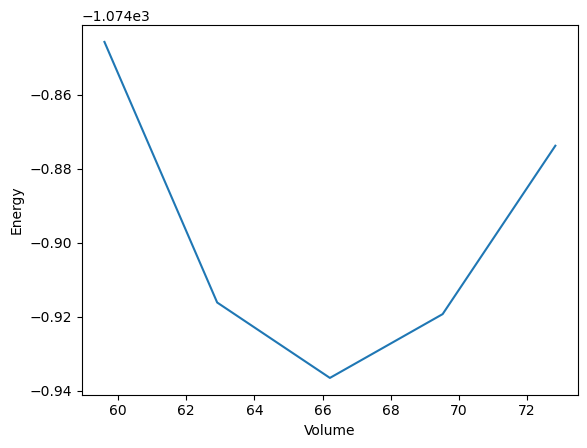

In [14]:
plot.pull()

## Submission to an HPC / Check pointing / Error handling
While the local installation of the `pyiron_base` workflow manager requires no additional configuration, the connection to an HPC system is more evolved. The existing examples provided for specific HPC systems can be converted to jinja2 templates, by defining variables with double curly brackets. A minimalist template could be: 
```
#!/bin/bash
#SBATCH --job-name={{job_name}}
#SBATCH --chdir={{working_directory}}
#SBATCH --cpus-per-task={{cores}}

{{command}}
```
Here the `job_name`, the `working_directory` and the number of compute `cores` can be specified as parameters. In the `pyiron_base` workflow manager such a submission script can then be selected based on its name as parameter of the `server` object:
```python
job_workflow.server.queue = "my_queue"
job_workflow.server.cores = 64
```
These lines are inserted before calling the `run()` function. The rest of the simulation protocol remains the same.

When simulation protocols are up-scaling and iterated over a large number of parameters, certain parameter combinations might lead to poor conversion or even cause simulation code crashes. In the `pyiron_base` workflow manager these calculation are marked as `aborted`. This gives the user to inspect the calculation and in case the crash was not related to the parameter combination, individual jobs can be removed with the `remove_job()` function. Afterwards, the simulation protocol can be executed again. In this case the `pyiron_base` workflow manager recognizes the already completed calculation and only re-evaluates the removed broken calculation. 

## Data Storage / Data Sharing
In the `pyiron_base` workflow manager the input of the calculation as well as the output are stored in the hierachical data format (HDF). In addition, `pyiron_base` can use a Structured Query Language (SQL) database, which acts as an index of all the `Job` objects and their HDF5 files. This file-based approach allows the user easily to browse through the results and at the same time the compressed storage in HDF5 and the internal hierarchy of the data format, enable the efficient storage of large tensors, like atomistic trajectories. 

## Publication of the workflow
The `pyiron_base` workflow manager provides a publication template to publish simulation workflows on Github. This template enables both the publication of the workflow as well as the publication of the results generated with a given workflow. For reproduciblity this publication template is based on sharing a conda environment file `environment.yml` in combination with the Jupyter notebook containing the simulation protocol and the archived `Job` objects. The Jupyter notebook is then rendered as static website with links to enable interactive execution using Jupyterbook and the mybinder service. As the `pyiron_base` workflow manager reloads existing calculation from the archive, a user of the interactive mybinder environment does not have to recompute the computationally expensive steps and still has the opportunity to interact with the provided workflow and data. 